**References**

Jason Brownlee's blog post: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [6]:
import sys
pyversion = '{}.{}'.format(sys.version_info.major, sys.version_info.minor)
print('python version: ' + pyversion)
import keras
import tensorflow as tf
print("tensorflow version: " + tf.__version__)
from keras.datasets import mnist
print('keras version: ' + keras.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

python version: 3.4
tensorflow version: 1.3.0
keras version: 2.0.8


(60000, 28, 28)
(60000,)


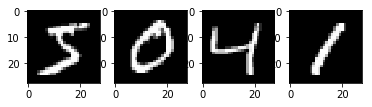

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
for i in range(4):
    plt.subplot(141+i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
print(X_train.shape)
print(y_train.shape)

## Baseline Model with Multi-Layer Perceptrons

In [8]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
seed = 7

In [9]:
numpy.random.seed(seed)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
# Flatten 28x28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# Normalize pixel values to 0. to 1.
X_train /= 255.0
X_test /= 255.0

In [11]:
# One-hot encodes the output
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print(y_train.shape)

(60000, 10)


In [12]:
# Split the training and validation set
idx = numpy.hstack([numpy.ones(10000), numpy.zeros(50000)])
numpy.random.shuffle(idx)
X_train, X_valid = X_train[idx==0, :], X_train[idx==1, :]
y_train, y_valid = y_train[idx==0], y_train[idx==1]

Now Define the Model. We use a simple neural network with one hidden layer with the same number of neurons as the inputs (784). A Rrectifier activation function is used for the neurons in the hidden layer. 

![OneLayerNN](https://github.com/giantwhale/StudyNotes/blob/master/DeepLearning/imgs/neural_net_one_layer_fully_connected.jpg?raw=true)

In [13]:
def baseline_model():
    model = Sequential()
    model.add(Dense(num_pixels, # output has the same length as the input 
                    input_dim=num_pixels, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [20]:
model = baseline_model()
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10,
         batch_size=200, verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
2s - loss: 0.3102 - acc: 0.9115 - val_loss: 0.1561 - val_acc: 0.9554
Epoch 2/10
1s - loss: 0.1246 - acc: 0.9640 - val_loss: 0.1179 - val_acc: 0.9649
Epoch 3/10
1s - loss: 0.0807 - acc: 0.9763 - val_loss: 0.0888 - val_acc: 0.9747
Epoch 4/10
1s - loss: 0.0562 - acc: 0.9837 - val_loss: 0.0809 - val_acc: 0.9759
Epoch 5/10
1s - loss: 0.0400 - acc: 0.9890 - val_loss: 0.0757 - val_acc: 0.9785
Epoch 6/10
1s - loss: 0.0302 - acc: 0.9921 - val_loss: 0.0726 - val_acc: 0.9802
Epoch 7/10
1s - loss: 0.0229 - acc: 0.9941 - val_loss: 0.0689 - val_acc: 0.9811
Epoch 8/10
1s - loss: 0.0165 - acc: 0.9962 - val_loss: 0.0755 - val_acc: 0.9790
Epoch 9/10
1s - loss: 0.0134 - acc: 0.9972 - val_loss: 0.0645 - val_acc: 0.9824
Epoch 10/10
1s - loss: 0.0091 - acc: 0.9984 - val_loss: 0.0719 - val_acc: 0.9802


In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: {:.2f}%".format(100 - scores[1] * 100))

Baseline Error: 1.85%


## Simple CNN

References: https://keras.io/layers/convolutional/

In [27]:
import numpy 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
seed = 7
numpy.random.seed(seed)

When using Convolutional Neural Network, we take into consideration the geometric location of each pixel. 

In [28]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
# Note: we are using gray scale here, so pixels is set to 1. For RGB colored
#       images, we set pixels to 3.
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# Standarization
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [29]:
# Split the training and validation set
idx = numpy.hstack([numpy.ones(10000), numpy.zeros(50000)])
numpy.random.shuffle(idx)
X_train, X_valid = X_train[idx==0, :], X_train[idx==1, :]
y_train, y_valid = y_train[idx==0], y_train[idx==1]

Next, we define our CNN model.

1. The first layer is a conv layer with 32 feature maps, which with the size of 5x5 and a RELU activation. (Each **filter** is a 5x5 pad that we use to scan over the image. thus the output tensor has 32 layers as the last dimension).

2. Next we define a **Max Pooling** layer.

3. The next layer is a regularization layer using **Dropout** with rate 20%.

4. Next is a layer that converts the 2D matrix data to a vector through the **Flatten** operation. 

5. Next a fully connected layer with 128 neurons and RELU activation

6. Finally, the output layer.

In [30]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), 
                     input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
model = cnn_model()
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
          epochs=10, batch_size=200, verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
9s - loss: 0.2729 - acc: 0.9225 - val_loss: 0.1030 - val_acc: 0.9706
Epoch 2/10
8s - loss: 0.0805 - acc: 0.9758 - val_loss: 0.0626 - val_acc: 0.9831
Epoch 3/10
8s - loss: 0.0533 - acc: 0.9837 - val_loss: 0.0533 - val_acc: 0.9842
Epoch 4/10
8s - loss: 0.0423 - acc: 0.9872 - val_loss: 0.0462 - val_acc: 0.9868
Epoch 5/10
8s - loss: 0.0344 - acc: 0.9888 - val_loss: 0.0432 - val_acc: 0.9868
Epoch 6/10
8s - loss: 0.0287 - acc: 0.9907 - val_loss: 0.0417 - val_acc: 0.9877
Epoch 7/10
8s - loss: 0.0224 - acc: 0.9930 - val_loss: 0.0418 - val_acc: 0.9883
Epoch 8/10
8s - loss: 0.0195 - acc: 0.9936 - val_loss: 0.0432 - val_acc: 0.9879
Epoch 9/10
8s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0376 - val_acc: 0.9889
Epoch 10/10
8s - loss: 0.0145 - acc: 0.9954 - val_loss: 0.0400 - val_acc: 0.9887


## Larger Convolutional Neural Network for MNIST

In [32]:
seed = 7
numpy.random.seed(seed)

In [33]:
def larger_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
model = larger_model()
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=200)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s - loss: 0.4419 - acc: 0.8628 - val_loss: 0.0993 - val_acc: 0.9741
Epoch 2/10
50000/50000 [==============================] - 9s - loss: 0.1026 - acc: 0.9685 - val_loss: 0.0646 - val_acc: 0.9823
Epoch 3/10
50000/50000 [==============================] - 9s - loss: 0.0755 - acc: 0.9765 - val_loss: 0.0529 - val_acc: 0.9857
Epoch 4/10
50000/50000 [==============================] - 9s - loss: 0.0626 - acc: 0.9809 - val_loss: 0.0461 - val_acc: 0.9869
Epoch 5/10
50000/50000 [==============================] - 9s - loss: 0.0532 - acc: 0.9830 - val_loss: 0.0448 - val_acc: 0.9871
Epoch 6/10
50000/50000 [==============================] - 9s - loss: 0.0466 - acc: 0.9857 - val_loss: 0.0430 - val_acc: 0.9877
Epoch 7/10
50000/50000 [==============================] - 9s - loss: 0.0408 - acc: 0.9873 - val_loss: 0.0389 - val_acc: 0.9882
Epoch 8/10
50000/50000 [==============================] - 9s

## Debug Model

In [35]:
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), 
                     input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

In [64]:
from keras.layers import Input

x = Input(X_train.shape[1:])
print(x)

conv1 = Conv2D(filters=32, kernel_size=(5, 5))(x)
print(conv1)

conv1a = Conv2D(filters=32, kernel_size=(5, 5), padding='same')(x)
print(conv1a)

maxpooled = MaxPooling2D(pool_size=(2, 2))(conv1)
print(maxpooled)

dropped = Dropout(0.2)(maxpooled)
print(dropped)

flattened = Flatten()(dropped)
print(flattened)

Tensor("input_25:0", shape=(?, 1, 28, 28), dtype=float32)
Tensor("conv2d_52/add:0", shape=(?, 32, 24, 24), dtype=float32)
Tensor("conv2d_53/add:0", shape=(?, 32, 28, 28), dtype=float32)
Tensor("max_pooling2d_27/transpose_1:0", shape=(?, 32, 12, 12), dtype=float32)
Tensor("dropout_22/cond/Merge:0", shape=(?, 32, 12, 12), dtype=float32)
Tensor("flatten_20/Reshape:0", shape=(?, ?), dtype=float32)


## Model Visualization

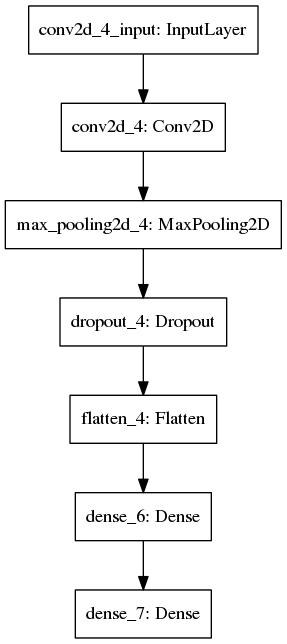

In [16]:
from keras.utils import plot_model
model = cnn_model()
plot_model(model, to_file='model.png')

from IPython.display import Image
Image(filename='model.png') 